## Continuous Monitoring in Traditional A/B Testing

---

You're **running a bold A/B test on your website**. Opinion is divided on whether the test is likely to be a success or not. 
- If it is a success, your stakeholders will want to launch the change as soon as possible; any delay results in major profits being lost. 
- On the other hand, an unsuccessful test may result in the company losing money or harming the user experience; in this case, you want to know about it as soon as possible, in order to stop the experiment. 

For any experiment, **there is value in detecting real effects as quickly as possible, and high opportunity cost in waiting to end a test.**

Because of this, you may find yourself under pressure to check the results of your experiments on an ongoing basis. Each day, you may compute significance on your key metrics, and if those results are statistically significant, stop the experiment regardless of whether the sample size requirements have been met. This blog demonstrates that the effect of **continuously monitoring** or **peeking** at the results of your A/B experiments is a dramatic increase in your type I error rate, far above the alpha level chosen. 

Existing explanations already provide an explanation for this phenomenon. Two of my favourites include [How Not To Run an A/B Test](http://www.evanmiller.org/how-not-to-run-an-ab-test.html) and this [answer from StackExchange](https://stats.stackexchange.com/a/310132). 

In this blog post, I'll **use simulation to demonstrate the pernicious effect of continuous monitoring**. In the example, both the treatment and control sets are drawn from the same population. Given that both datasets are drawn from the same population, we know that we should only expect a positive result in 5% of cases (alpha = 0.05 in this example). I demonstrate that continuous monitoring greatly increases our type I error beyond the chosen alpha level.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [18]:
def generate_pvalue(sample_size, mu=5, sigma=1):
    """Produce a stream of p-values for a given sample_size"""
    
    # resample from our population each time    
    control = np.random.normal(mu, sigma, sample_size)
    variant = np.random.normal(mu, sigma, sample_size)

    # must compare a sample of at least 2
    for obs in range(2, sample_size):
        _ , pvalue = ttest_ind(control[:obs], variant[:obs])
        yield pvalue


def simulate_trials(sample_size, n_trials=300, alpha=0.05):
    """
    Returns the false positive rate if an experiment 
    is stopped the first time a result is significant
    """
    m = np.zeros(n_trials)
    for posn, trials in enumerate(range(n_trials)):
        pvalues = generate_pvalue(sample_size)
        for pvalue in pvalues:
            if pvalue < alpha:
                m[posn] = 1
                break
                
    # compute the standard error using the bootstrap
    boot = []
    for i in range(500):
        sample = np.random.choice(m, size=sample_size, replace=True)
        mean = np.mean(sample)
        boot.append(mean)
            
    fpr = np.mean(m)
    se = np.std(boot)
    
    return (fpr, se)

Compute results for a grid and plot

In [19]:
sample_sizes = np.logspace(0, 4, num=10)
sample_sizes = map(int, np.ceil(sample_sizes))

d = {}

# note this takes a while to run
for sample_size in sample_sizes:
    fpr, error = simulate_trials(sample_size)
    d[sample_size] = {}
    d[sample_size]['fpr'] = fpr
    d[sample_size]['error'] = error

Manipulate the Data for Plotting

In [20]:
df = pd.DataFrame(d)
df = df.T
df.index.name = "Sample Size"

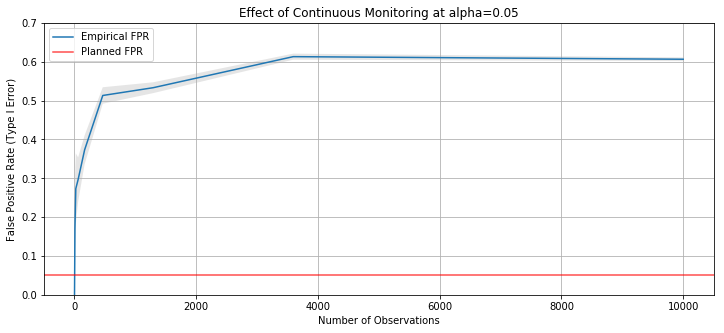

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
df['fpr'].plot(ax=ax, label='Empirical FPR')
ax.fill_between(df.index, df['fpr'],df['fpr'] - df['error'],facecolor='grey', interpolate=True, alpha=0.2)
ax.fill_between(df.index, df['fpr'],df['fpr'] + df['error'],facecolor='grey', interpolate=True, alpha=0.2)

plt.ylabel("False Positive Rate (Type I Error)", fontsize='medium')
plt.xlabel("Number of Observations", fontsize='medium');
plt.title("Effect of Continuous Monitoring at alpha=0.05")
plt.axhline(y=0.05, linestyle='-', color='red', alpha=0.7, label='Planned FPR')
plt.ylim([0, 0.7])

ax.legend(loc='best');
plt.grid(True)

### Comments

The chart above plots the empirical false positive rate for experiments of varying size.

For each experiment size, a number of trials were simulated. For each trial, the p-value was computed each time a new observation was collected. If the p-value fell below the given alpha level, the experiment results were deemed to be significant. This information was used to compute the false positive rate, by dividing the number of significant trials by the number of total trials. A measure of the standard error was obtained using the bootstrap and is used to create the 95% confidence interval plotted in light grey.

The chart above clearly shows the increase in the FPR rate as a result of continuously monitoring an experiment - increases as large as 10x the planned false positive rate.

### Conclusion & Parting Thoughts

**The validity of traditional A/B Tests require that the sample size be fixed in advance.**  The simulation above demonstrated that stopping experiments once results are significant results in a large increase in the false positive rate.

In the introduction, I detailed the value in detecting effects as quickly as possible. **So what can we do in this situation?**

- **Acknowledge and understand** why our stakeholders may want to see results before the sample size requirements are met.
- **Provide daily experiment updates**: This is a tip I picked up from Emily Robinson's talk [A/B Testing in the Wild](https://youtu.be/SF-ryGgLOgQ?t=2100). Providing a daily email detailing any updates made in experiments helps:
    - provide interpretation to the numbers that your stakeholders may be viewing: is this normal? Should I be worried?
    - demonstrates that you're on top of things.
- Implement an **early-stopping methodology**.